# Dirichlet mixtures of multinomials

:::{post} Sept 16, 2021
:tags: mixture model, pymc3.Dirichlet, pymc3.DirichletMultinomial, pymc3.Lognormal, pymc3.Model, pymc3.Multinomial
:category: advanced
:::

This example notebook demonstrates the use of a
Dirichlet mixture of multinomials
(a.k.a [Dirichlet-multinomial](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution) or DM)
to model categorical count data.
Models like this one are important in a variety of areas, including
natural language processing, ecology, bioinformatics, and more.

The Dirichlet-multinomial can be understood as draws from a [Multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution)
where each sample has a slightly different probability vector, which is itself drawn from a common [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution).
This contrasts with the Multinomial distribution, which assumes that all observations arise from a single fixed probability vector.
This enables the Dirichlet-multinomial to accommodate more variable (a.k.a, over-dispersed) count data than the Multinomial.

Other examples of over-dispersed count distributions are the
[Beta-binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution)
(which can be thought of as a special case of the DM) or the
[Negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution)
distributions.

The DM is also an example of marginalizing
a mixture distribution over its latent parameters.
This notebook will demonstrate the performance benefits that come from taking that approach.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import scipy.stats
import seaborn as sns

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Simulation data

Let us simulate some over-dispersed, categorical count data
for this example.

Here we are simulating from the DM distribution itself,
so it is perhaps tautological to fit that model,
but rest assured that data like these really do appear in
the counts of different:

1. words in text corpuses {cite:p}`madsen2005modelingdirichlet`,
2. types of RNA molecules in a cell {cite:p}`nowicka2016drimseq`,
3. items purchased by shoppers {cite:p}`goodhardt1984thedirichlet`.

Here we will discuss a community ecology example, pretending that we have observed counts of $k=5$ different
tree species in $n=10$ different forests.

Our simulation will produce a two-dimensional matrix of integers (counts)
where each row, (zero-)indexed by $i \in (0...n-1)$, is an observation (different forest), and each
column $j \in (0...k-1)$ is a category (tree species).
We'll parameterize this distribution with three things:
- $\mathrm{frac}$ : the expected fraction of each species,
  a $k$-dimensional vector on the simplex (i.e. sums-to-one)
- $\mathrm{total\_count}$ : the total number of items tallied in each observation,
- $\mathrm{conc}$ : the concentration, controlling the overdispersion of our data,
  where larger values result in our distribution more closely approximating the multinomial.
  
Here, and throughout this notebook, we've used a
[convenient reparameterization](https://mc-stan.org/docs/2_26/stan-users-guide/reparameterizations.html#dirichlet-priors)
of the Dirichlet distribution
from one to two parameters,
$\alpha=\mathrm{conc} \times \mathrm{frac}$, as this
fits our desired interpretation.
  
Each observation from the DM is simulated by:
1. first obtaining a value on the $k$-simplex simulated as
   $p_i \sim \mathrm{Dirichlet}(\alpha=\mathrm{conc} \times \mathrm{frac})$,
2. and then simulating $\mathrm{counts}_i \sim \mathrm{Multinomial}(\mathrm{total\_count}, p_i)$.

Notice that each observation gets its _own_
latent parameter $p_i$, simulated independently from
a common Dirichlet distribution.

In [3]:
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
trees = ["pine", "oak", "ebony", "rosewood", "mahogany"]  # Different tree species observed
forests = [
    "sunderbans",
    "amazon",
    "arashiyama",
    "trossachs",
    "valdivian",
    "bosc de poblet",
    "font groga",
    "monteverde",
    "primorye",
    "daintree",
]  # Forests observed
k = len(trees)
n = len(forests)
total_count = 50

true_p = sp.stats.dirichlet(true_conc * true_frac).rvs(size=n)
observed_counts = np.vstack([sp.stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p])

observed_counts

array([[16,  9, 25,  0,  0],
       [20, 15,  7,  1,  7],
       [18, 27,  4,  1,  0],
       [24,  2,  3, 21,  0],
       [21, 12,  6, 11,  0],
       [38,  6,  1,  5,  0],
       [38,  5,  0,  7,  0],
       [30, 12,  0,  8,  0],
       [26, 18,  2,  4,  0],
       [16,  1,  7, 26,  0]])

## Multinomial model

The first model that we will fit to these data is a plain
multinomial model, where the only parameter is the
expected fraction of each category, $\mathrm{frac}$, which we will give a Dirichlet prior.
While the uniform prior ($\alpha_j=1$ for each $j$) works well, if we have independent beliefs about the fraction of each tree,
we could encode this into our prior, e.g.
increasing the value of $\alpha_j$ where we expect a higher fraction of species-$j$.

In [4]:
coords = {"tree": trees, "forest": forests}

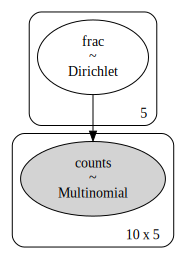

In [5]:
with pm.Model(coords=coords) as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    counts = pm.Multinomial(
        "counts", n=total_count, p=frac, observed=observed_counts, dims=("forest", "tree")
    )

pm.model_to_graphviz(model_multinomial)

Interestingly, NUTS frequently runs into numerical problems on this model, perhaps an example of the
["Folk Theorem of Statistical Computing"](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/).

Because of a couple of identities of the multinomial distribution,
we could reparameterize this model in a number of ways&mdash;we
would obtain equivalent models by exploding our $n$ observations
of $\mathrm{total\_count}$ items into $(n \times \mathrm{total\_count})$
independent categorical trials, or collapsing them down into
one Multinomial draw with $(n \times \mathrm{total\_count})$ items.
(Importantly, this is _not_ true for the DM distribution.)

Rather than _actually_ fixing our problem through reparameterization,
here we'll instead switch to the Metropolis step method,
which ignores some of the geometric pathologies of our naïve model.

**Important**: switching to Metropolis does not not _fix_ our model's issues, rather it _sweeps them under the rug_.
In fact, if you try running this model with NUTS (PyMC3's default step method), it will break loudly during sampling.
When that happens, this should be a **red alert** that there is something wrong in our model.

You'll also notice below that we have to increase considerably the number of draws we take from the posterior;
this is because Metropolis is much less efficient at
exploring the posterior than NUTS.

In [6]:
with model_multinomial:
    trace_multinomial = pm.sample(
        draws=5000, chains=4, step=pm.Metropolis(), return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [frac]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
The number of effective samples is smaller than 10% for some parameters.


0, dim: forest, 10 =? 10
1, dim: tree, 1 =? 5


Let's ignore the warning about inefficient sampling for now.

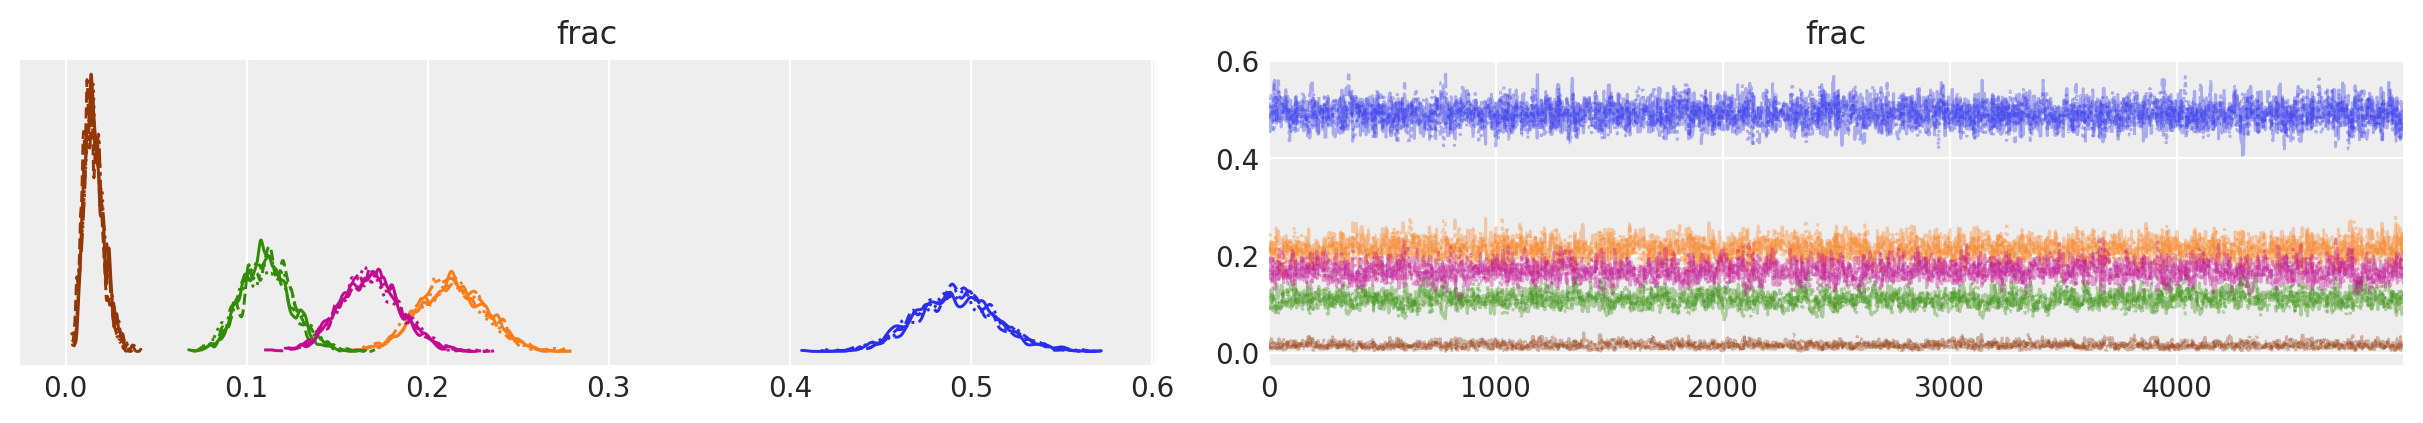

In [7]:
az.plot_trace(data=trace_multinomial, var_names=["frac"]);

The trace plots look fairly good;
visually, each parameter appears to be moving around the posterior well,
although some sharp parts of the KDE plot suggests that
sampling sometimes gets stuck in one place for a few steps.

In [8]:
summary_multinomial = az.summary(trace_multinomial, var_names=["frac"])

summary_multinomial = summary_multinomial.assign(
    ess_bulk_per_sec=lambda x: x.ess_bulk / trace_multinomial.posterior.sampling_time,
)

summary_multinomial

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,ess_bulk_per_sec
frac[0],0.492,0.022,0.450,0.534,0.0,0.0,2242.0,3032.0,1.00,622.321753
frac[1],0.213,0.019,0.179,0.247,0.0,0.0,1788.0,2610.0,1.00,496.302986
frac[2],0.111,0.014,0.084,0.137,0.0,0.0,918.0,1727.0,1.00,254.813278
frac[3],0.168,0.017,0.138,0.200,0.0,0.0,1316.0,1924.0,1.00,365.287880
frac[4],0.016,0.006,0.006,0.026,0.0,0.0,809.0,1283.0,1.01,224.557671


Likewise, diagnostics in the parameter summary table all look fine.
Here I've added a column estimating the effective sample size per
second of sampling.

Nonetheless, the fact that we were unable to use NUTS is still a red flag, and we should be
very cautious in using these results.

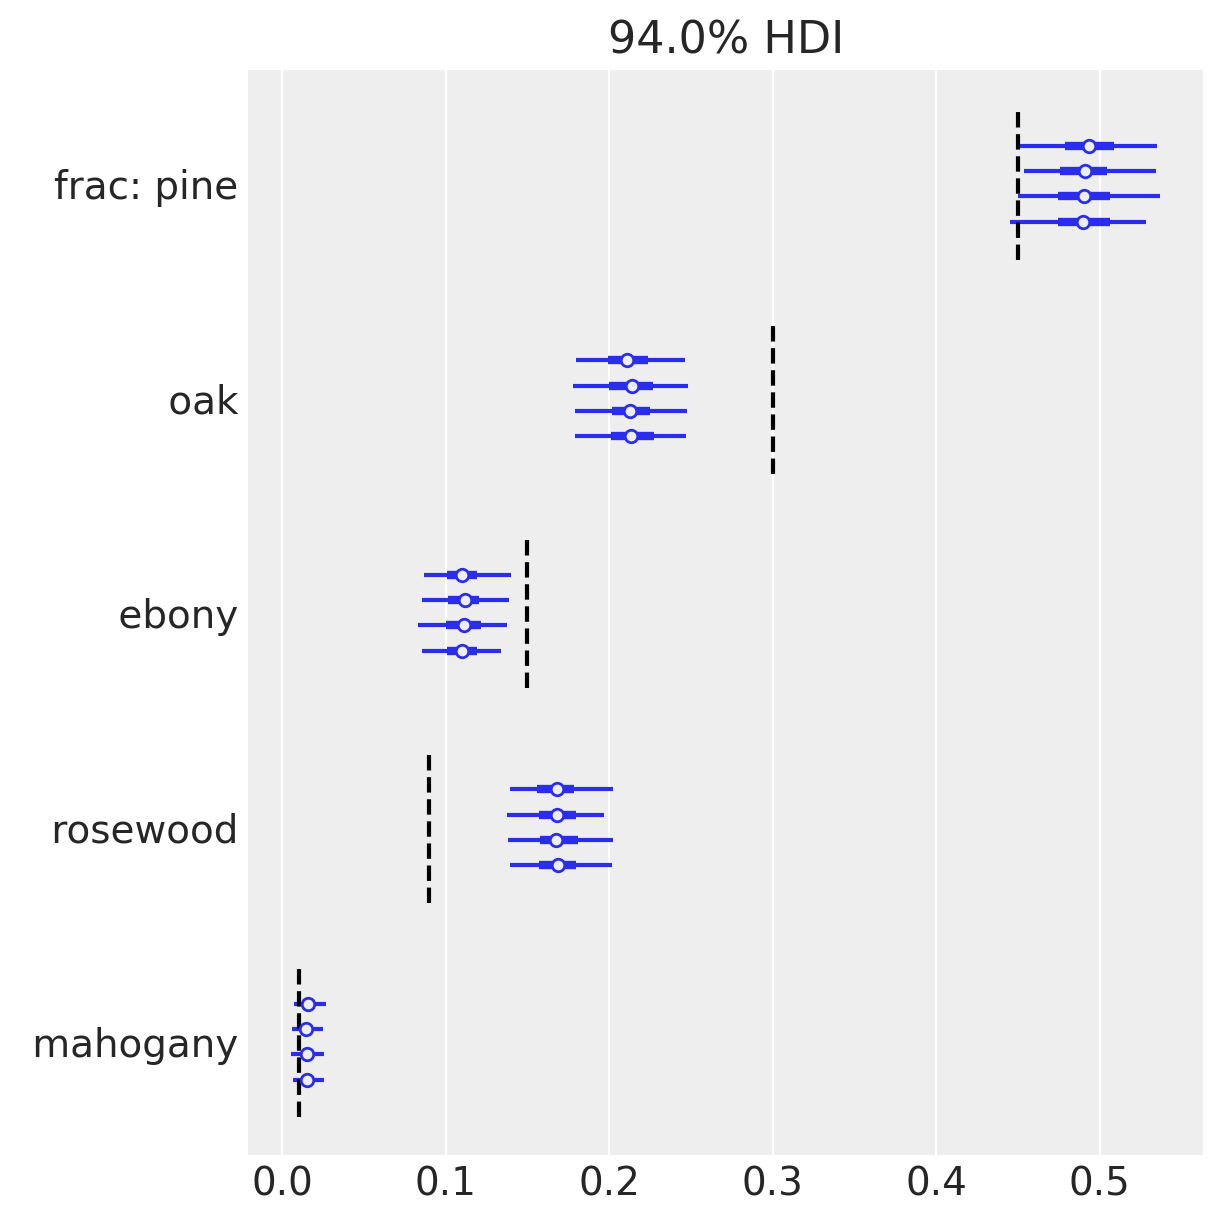

In [9]:
az.plot_forest(trace_multinomial, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

Here we've drawn a forest-plot, showing the mean and 94% HDIs from our posterior approximation.
Interestingly, because we know what the underlying
frequencies are for each species (dashed lines), we can comment on the accuracy
of our inferences.
And now the issues with our model become apparent;
notice that the 94% HDIs _don't include the true values_ for
tree species 0, 2, 3.
We might have seen _one_ HDI miss, but _three_???

...what's going on?

Let's troubleshoot this model using a posterior-predictive check, comparing our data to simulated data conditioned on our posterior estimates.

In [10]:
with model_multinomial:
    ppc = pm.fast_sample_posterior_predictive(trace=trace_multinomial)

# Concatenate with InferenceData object
trace_multinomial.extend(az.from_pymc3(posterior_predictive=(ppc), model=model_multinomial))

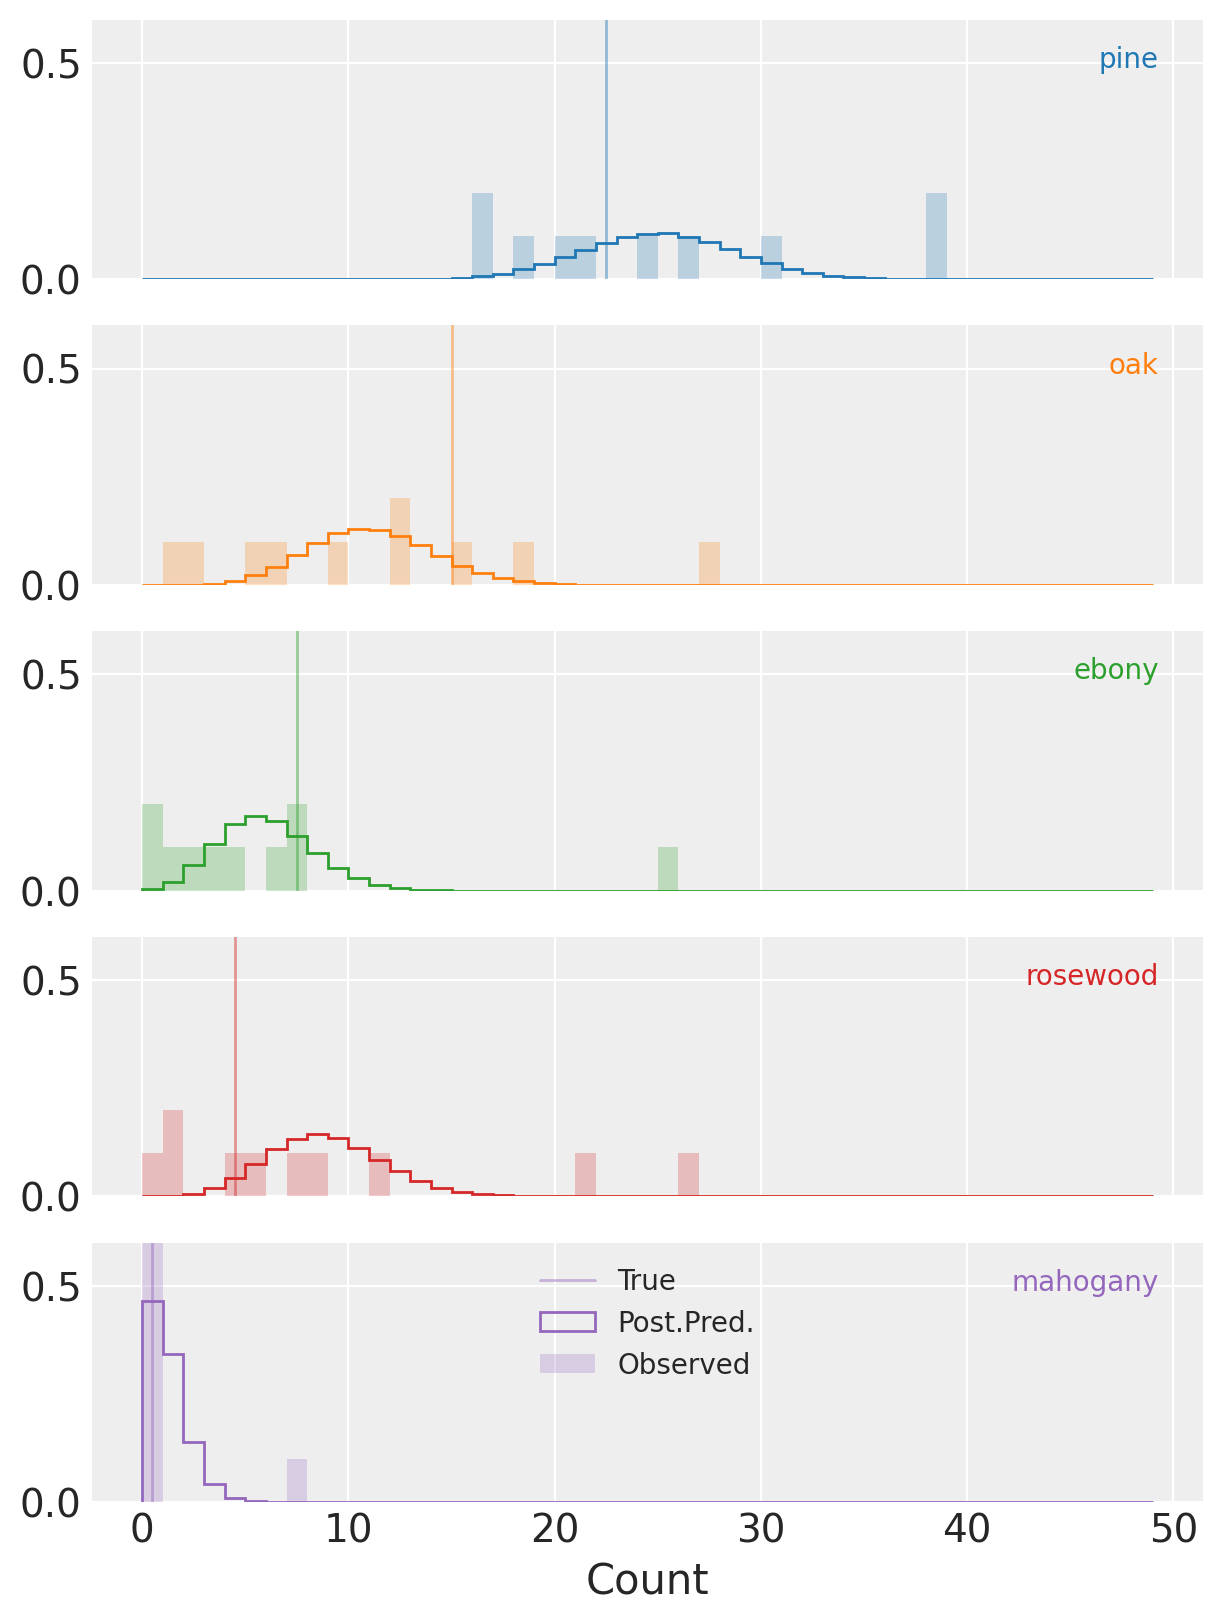

In [11]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(k, 1, sharex=True, sharey=True, figsize=(6, 8))
for j, ax in enumerate(axs):
    c = cmap(j)
    ax.hist(
        trace_multinomial.posterior_predictive.counts.sel(tree=trees[j]).values.flatten(),
        bins=np.arange(total_count),
        histtype="step",
        color=c,
        density=True,
        label="Post.Pred.",
    )
    ax.hist(
        (trace_multinomial.observed_data.counts.sel(tree=trees[j]).values.flatten()),
        bins=np.arange(total_count),
        color=c,
        density=True,
        alpha=0.25,
        label="Observed",
    )
    ax.axvline(
        true_frac[j] * total_count,
        color=c,
        lw=1.0,
        alpha=0.45,
        label="True",
    )
    ax.annotate(
        f"{trees[j]}",
        xy=(0.96, 0.9),
        xycoords="axes fraction",
        ha="right",
        va="top",
        color=c,
    )

axs[-1].legend(loc="upper center", fontsize=10)
axs[-1].set_xlabel("Count")
axs[-1].set_yticks([0, 0.5, 1.0])
axs[-1].set_ylim(0, 0.6);

Here we're plotting histograms of the predicted counts
against the observed counts for each species.

_(Notice that the y-axis isn't full height and clips the distributions for species-4 in purple.)_

And now we can start to see why our posterior HDI deviates from the _true_ parameters for three of five species (vertical lines).
See that for all of the species the observed counts are frequently quite far from the predictions
conditioned on the posterior distribution.
This is particularly obvious for (e.g.) species-2 where we have one observation of more than 20
trees of this species, despite the posterior predicitive mass being concentrated far below that.

This is overdispersion at work, and a clear sign that we need to adjust our model to accomodate it.

Posterior predictive checks are one of the best ways to diagnose model misspecification,
and this example is no different.

## Dirichlet-Multinomial Model - Explicit Mixture

Let's go ahead and model our data using the DM distribution.

For this model we'll keep the same prior on the expected frequencies of each
species, $\mathrm{frac}$.
We'll also add a strictly positive parameter, $\mathrm{conc}$, for the concentration.

In this iteration of our model we'll explicitly include the latent multinomial
probability, $p_i$, modeling the $\mathrm{true\_p}_i$ from our simulations (which we would not
observe in the real world).

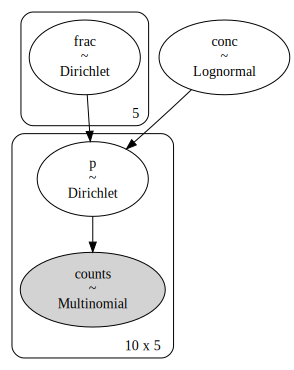

In [12]:
with pm.Model(coords=coords) as model_dm_explicit:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    p = pm.Dirichlet("p", a=frac * conc, dims=("forest", "tree"))
    counts = pm.Multinomial(
        "counts", n=total_count, p=p, observed=observed_counts, dims=("forest", "tree")
    )

pm.model_to_graphviz(model_dm_explicit)

Compare this diagram to the first.
Here the latent, Dirichlet distributed $p$ separates the multinomial from the expected frequencies, $\mathrm{frac}$,
accounting for overdispersion of counts relative to the simple multinomial model.

In [13]:
with model_dm_explicit:
    trace_dm_explicit = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, conc, frac]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6669735756236075, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: forest, 10 =? 10
1, dim: tree, 1 =? 5


We got a warning, although we'll ignore it for now.
More interesting is how much longer it took to sample this model than the
first.
This may be because our model has an additional ~$(n \times k)$ parameters,
but it seems like there are other geometric challenges for NUTS as well.

We'll see if we can fix these in the next model, but for now let's take a look at the traces.

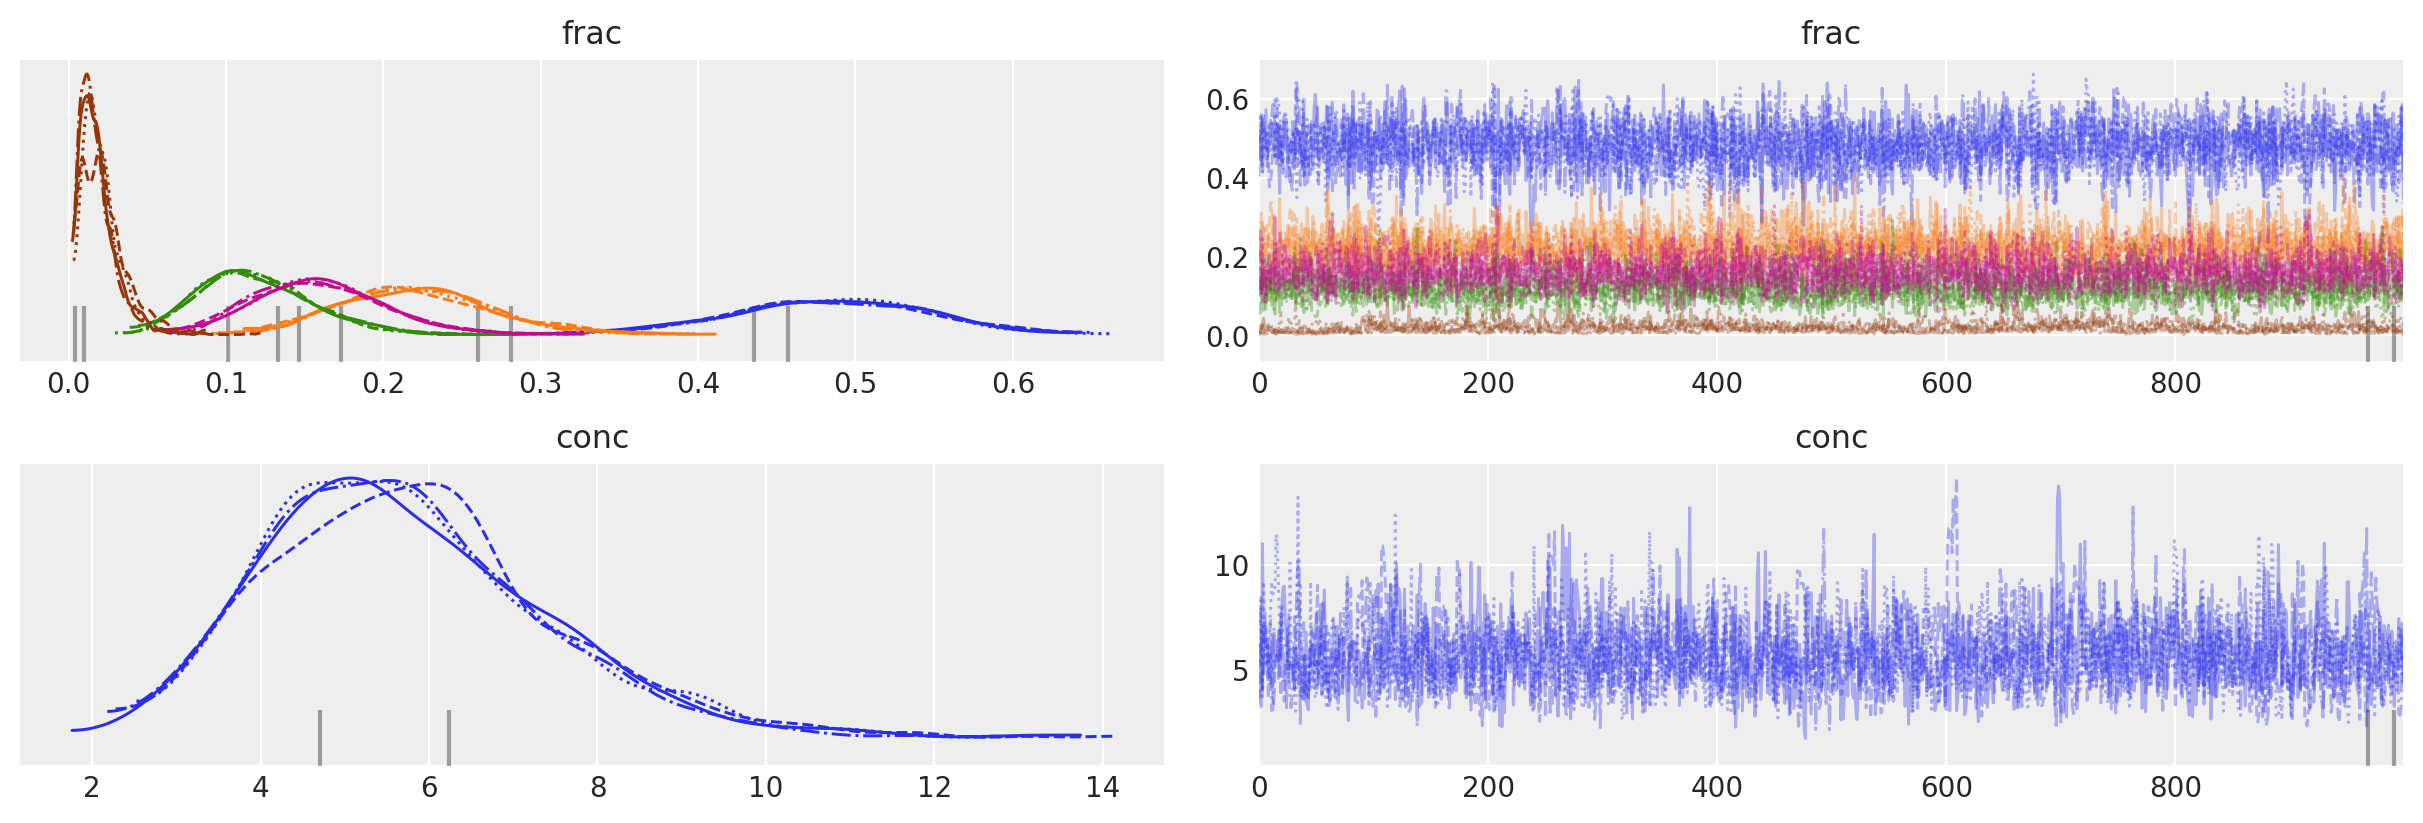

In [14]:
az.plot_trace(data=trace_dm_explicit, var_names=["frac", "conc"]);

Obviously some sampling issues, but it's hard to see where divergences are occurring.

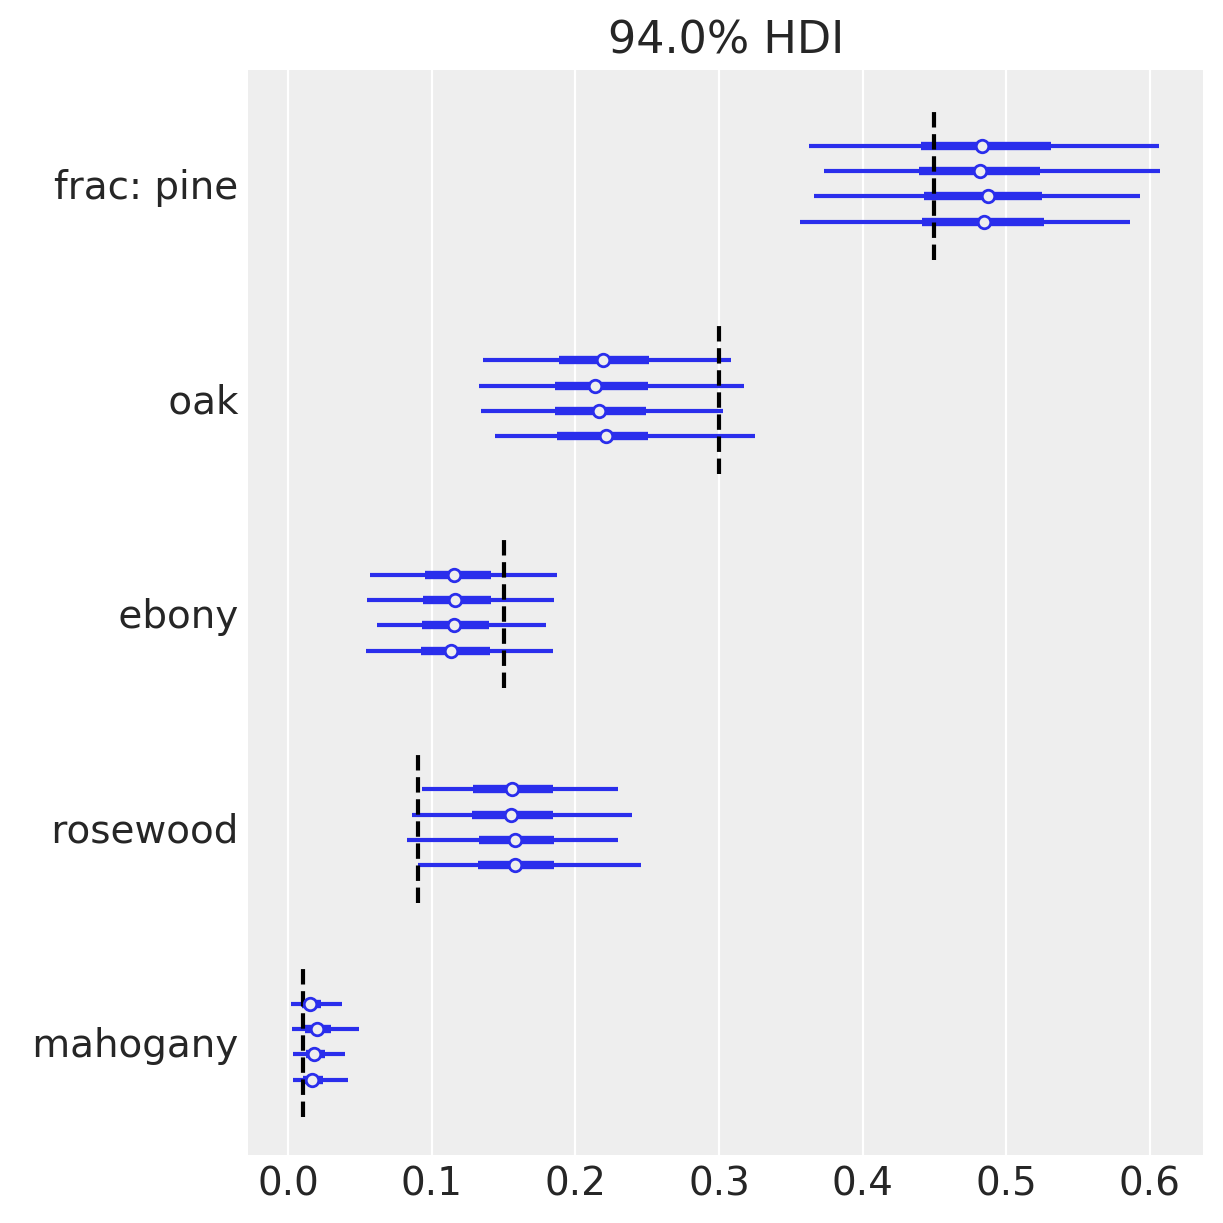

In [15]:
az.plot_forest(trace_dm_explicit, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

On the other hand, since we know the ground-truth for $\mathrm{frac}$,
we can congratulate ourselves that
the HDIs include the true values for all of our species!

Modeling this mixture has made our inferences robust to the overdispersion of counts,
while the plain multinomial is very sensitive.
Notice that the HDI is much wider than before for each $\mathrm{frac}_i$.
In this case that makes the difference between correct and incorrect inferences.

In [16]:
summary_dm_explicit = az.summary(trace_dm_explicit, var_names=["frac", "conc"])
summary_dm_explicit = summary_dm_explicit.assign(
    ess_bulk_per_sec=lambda x: x.ess_bulk / trace_dm_explicit.posterior.sampling_time,
)

summary_dm_explicit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,ess_bulk_per_sec
frac[0],0.482,0.063,0.369,0.605,0.001,0.001,2845.0,2454.0,1.00,55.694527
frac[1],0.220,0.048,0.126,0.307,0.001,0.001,2656.0,2359.0,1.00,51.994609
frac[2],0.119,0.035,0.054,0.183,0.001,0.001,2295.0,1929.0,1.00,44.927571
frac[3],0.159,0.040,0.082,0.232,0.001,0.001,2438.0,1605.0,1.00,47.726979
frac[4],0.020,0.012,0.003,0.042,0.001,0.001,119.0,420.0,1.02,2.329578
conc,5.732,1.684,2.831,8.907,0.044,0.032,1600.0,1540.0,1.00,31.322054


This is great, but _we can do better_.
The larger $\hat{R}$ value for $\mathrm{frac}_4$ is mildly concerning, and it's surprising
that our $\mathrm{ESS} \; \mathrm{sec}^{-1}$ is relatively small.

## Dirichlet-Multinomial Model - Marginalized

Happily, the Dirichlet distribution is conjugate to the multinomial
and therefore there's a convenient, closed-form for the marginalized
distribution, i.e. the Dirichlet-multinomial distribution, which was added to PyMC3 in [3.11.0](https://github.com/pymc-devs/pymc3/releases/tag/v3.11.0).

Let's take advantage of this, marginalizing out the explicit latent parameter, $p_i$,
replacing the combination of this node and the multinomial
with the DM to make an equivalent model.

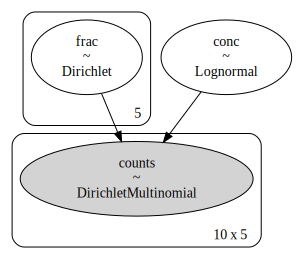

In [17]:
with pm.Model(coords=coords) as model_dm_marginalized:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial(
        "counts", n=total_count, a=frac * conc, observed=observed_counts, dims=("forest", "tree")
    )

pm.model_to_graphviz(model_dm_marginalized)

The plate diagram shows that we've collapsed what had been the latent Dirichlet and the multinomial
nodes together into a single DM node.

In [18]:
with model_dm_marginalized:
    trace_dm_marginalized = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conc, frac]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


0, dim: forest, 10 =? 10
1, dim: tree, 1 =? 5


It samples much more quickly and without any of the warnings from before!

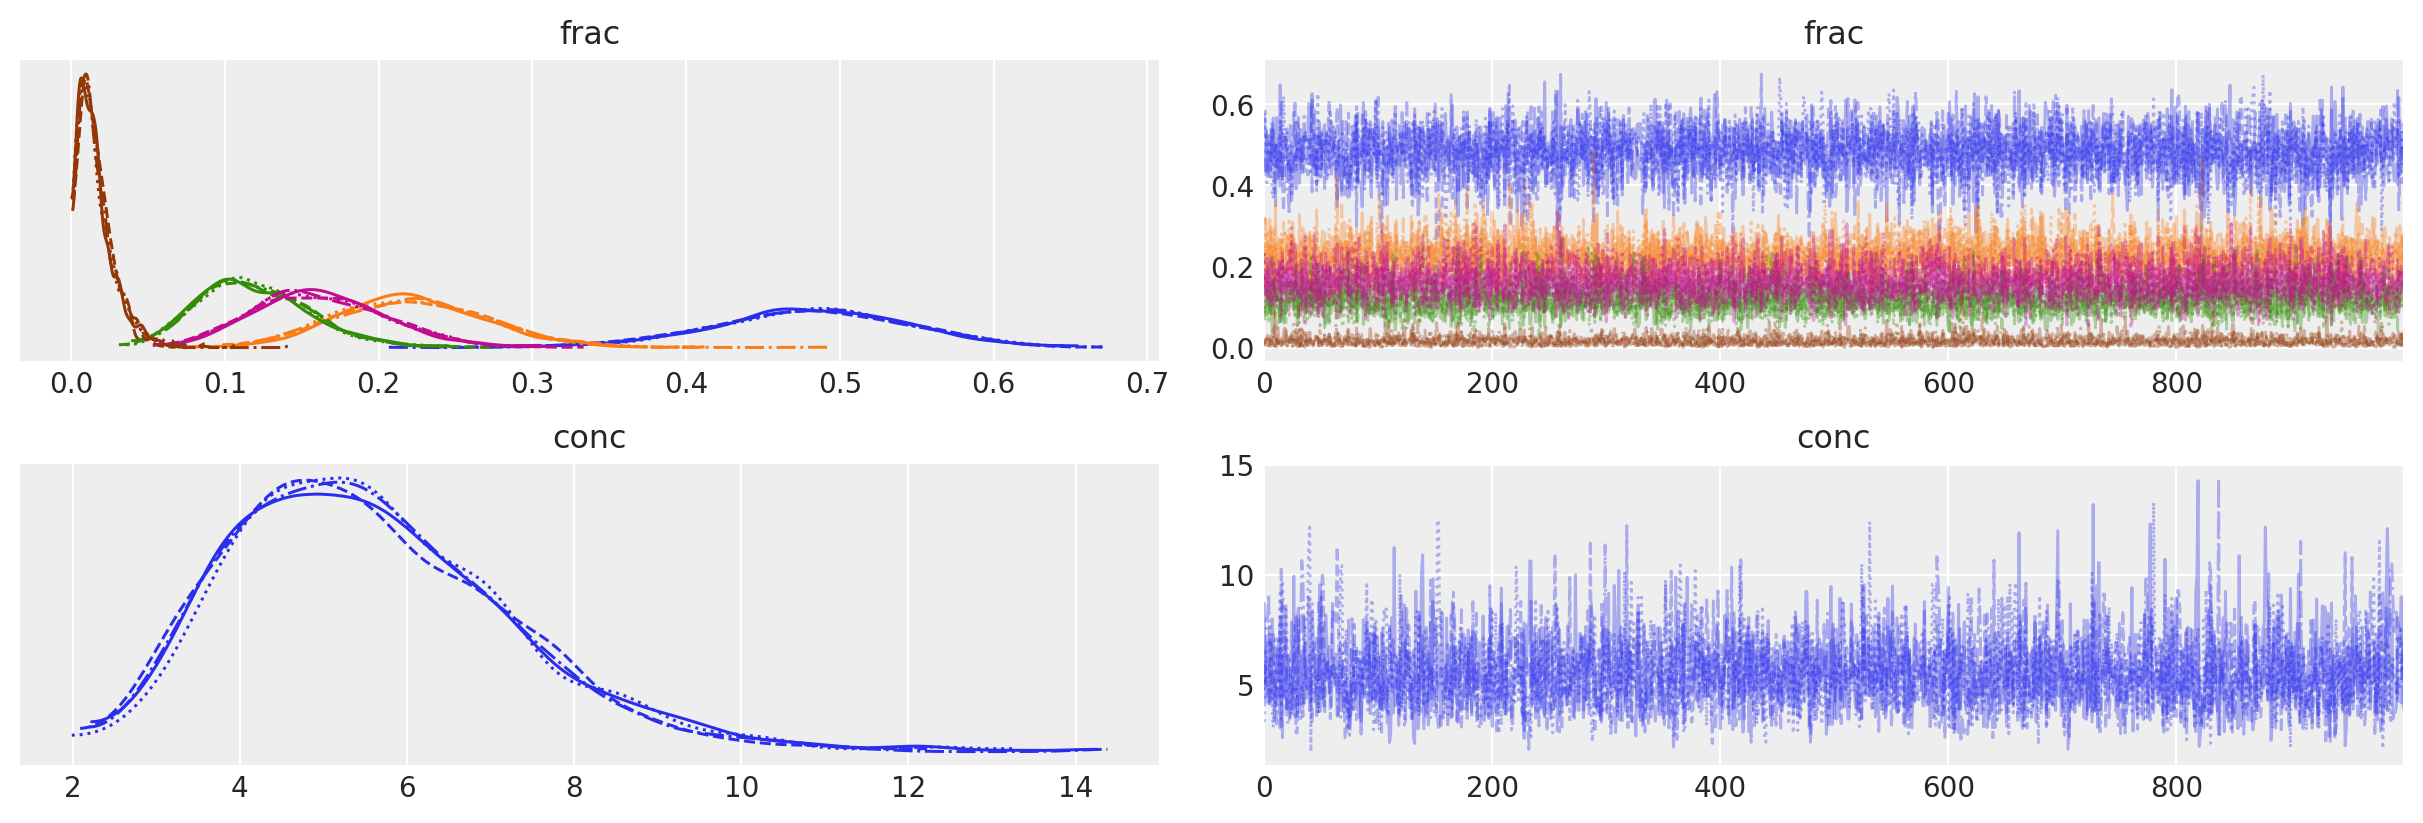

In [19]:
az.plot_trace(data=trace_dm_marginalized, var_names=["frac", "conc"]);

Trace plots look fuzzy and KDEs are clean.

In [20]:
summary_dm_marginalized = az.summary(trace_dm_marginalized, var_names=["frac", "conc"])
summary_dm_marginalized = summary_dm_marginalized.assign(
    ess_mean_per_sec=lambda x: x.ess_bulk / trace_dm_marginalized.posterior.sampling_time,
)
assert all(summary_dm_marginalized.r_hat < 1.03)

summary_dm_marginalized

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
frac[0],0.481,0.064,0.367,0.605,0.001,0.001,4628.0,2815.0,1.0,1511.959955
frac[1],0.222,0.049,0.134,0.314,0.001,0.001,5138.0,2803.0,1.0,1678.576112
frac[2],0.119,0.036,0.056,0.187,0.001,0.000,3936.0,2849.0,1.0,1285.884698
frac[3],0.162,0.043,0.087,0.245,0.001,0.000,5277.0,3195.0,1.0,1723.987183
frac[4],0.016,0.012,0.000,0.037,0.000,0.000,2827.0,2024.0,1.0,923.576230
conc,5.556,1.666,2.765,8.596,0.029,0.021,3279.0,2961.0,1.0,1071.243883


We see that $\hat{R}$ is close to $1$ everywhere
and $\mathrm{ESS} \; \mathrm{sec}^{-1}$ is much higher.
Our reparameterization (marginalization) has greatly improved the sampling!
(And, thankfully, the HDIs look similar to the other model.)

This all looks very good, but what if we didn't have the ground-truth?

Posterior predictive checks to the rescue (again)!

In [21]:
with model_dm_marginalized:
    ppc = pm.fast_sample_posterior_predictive(trace_dm_marginalized)

# Concatenate with InferenceData object
trace_dm_marginalized.extend(az.from_pymc3(posterior_predictive=ppc, model=model_dm_marginalized))

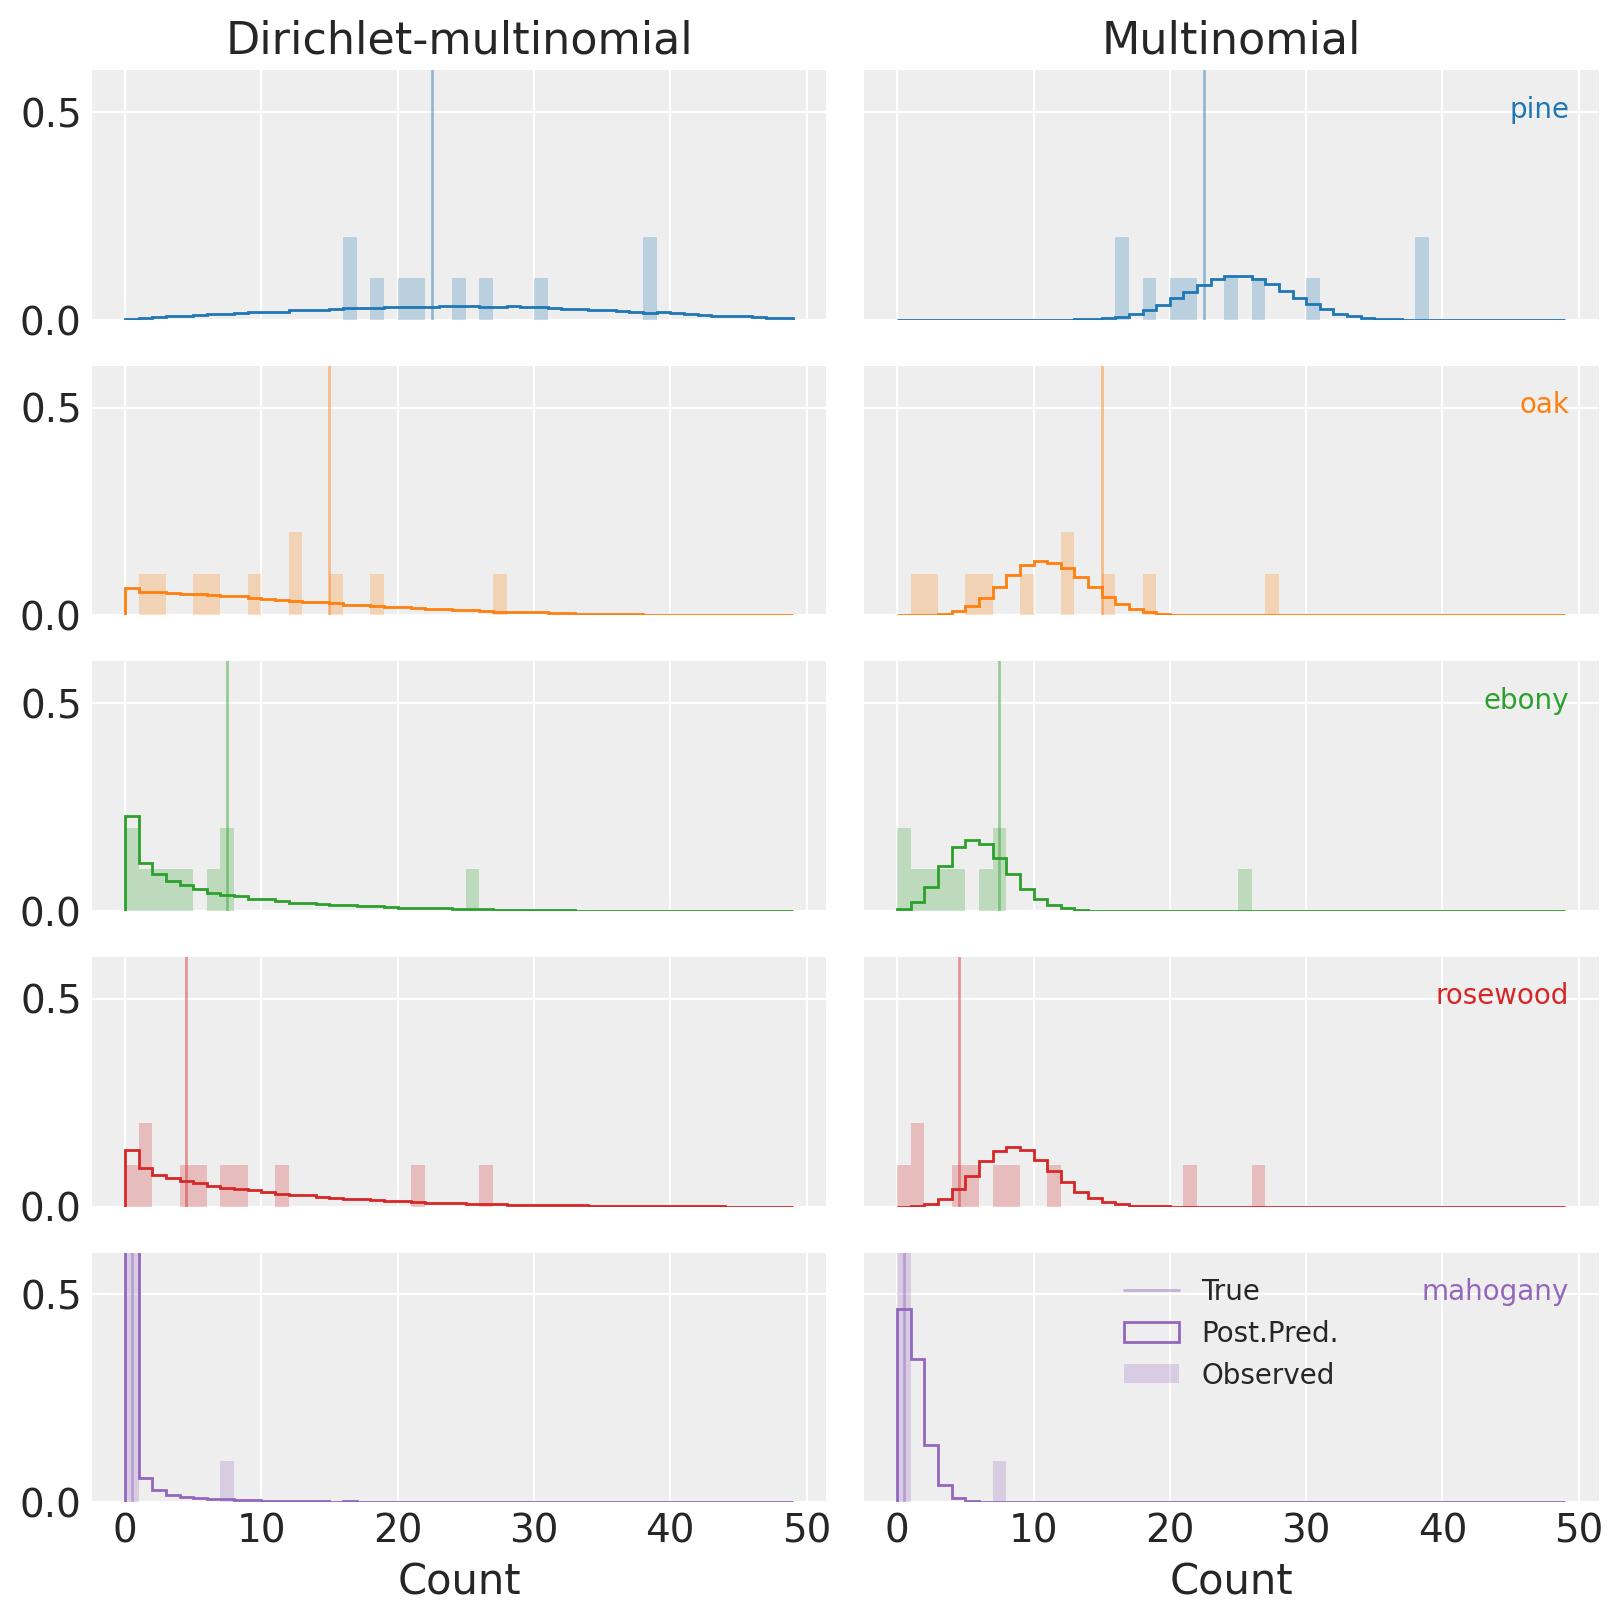

In [22]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(k, 2, sharex=True, sharey=True, figsize=(8, 8))
for j, row in enumerate(axs):
    c = cmap(j)
    for _trace, ax in zip([trace_dm_marginalized, trace_multinomial], row):
        ax.hist(
            _trace.posterior_predictive.counts.sel(tree=trees[j]).values.flatten(),
            bins=np.arange(total_count),
            histtype="step",
            color=c,
            density=True,
            label="Post.Pred.",
        )
        ax.hist(
            (_trace.observed_data.counts.sel(tree=trees[j]).values.flatten()),
            bins=np.arange(total_count),
            color=c,
            density=True,
            alpha=0.25,
            label="Observed",
        )
        ax.axvline(
            true_frac[j] * total_count,
            color=c,
            lw=1.0,
            alpha=0.45,
            label="True",
        )
    row[1].annotate(
        f"{trees[j]}",
        xy=(0.96, 0.9),
        xycoords="axes fraction",
        ha="right",
        va="top",
        color=c,
    )

axs[-1, -1].legend(loc="upper center", fontsize=10)
axs[0, 1].set_title("Multinomial")
axs[0, 0].set_title("Dirichlet-multinomial")
axs[-1, 0].set_xlabel("Count")
axs[-1, 1].set_xlabel("Count")
axs[-1, 0].set_yticks([0, 0.5, 1.0])
axs[-1, 0].set_ylim(0, 0.6)
ax.set_ylim(0, 0.6);

_(Notice, again, that the y-axis isn't full height, and clips the distributions for species-4 in purple.)_

Compared to the multinomial (plots on the right), PPCs for the DM (left) show that the observed data is
an entirely reasonable realization of our model.
This is great news!

## Model Comparison

Let's go a step further and try to put a number on how much better our DM model is
relative to the raw multinomial.
We'll use leave-one-out cross validation to compare the
out-of-sample predictive ability of the two.

In [23]:
az.compare(
    {"multinomial": trace_multinomial, "dirichlet_multinomial": trace_dm_marginalized}, ic="loo"
)

/home/ada/.local/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
dirichlet_multinomial,0,-102.486827,4.199577,0.000000,0.966435,5.779874,0.000000,False,log
multinomial,1,-198.548467,31.337934,96.061641,0.033565,28.784612,25.865024,True,log


Unsurprisingly, the DM outclasses the multinomial by a mile, assigning a weight of nearly
100% to the over-dispersed model.
We can conclude that between the two, the DM should be greatly favored for prediction,
parameter inference, etc.

## Conclusions

Obviously the DM is not a perfect model in every case, but it is often a better choice than the multinomial, much more robust while taking on just one additional parameter.

There are a number of shortcomings to the DM that we should keep in mind when selecting a model.
The biggest problem is that, while more flexible than the multinomial, the DM
still ignores the possibility of underlying correlations between categories.
If one of our tree species relies on another, for instance, the model we've used here
will not effectively account for this.
In that case, swapping the vanilla Dirichlet distribution for something fancier (e.g. the [Generalized Dirichlet](https://en.wikipedia.org/wiki/Generalized_Dirichlet_distribution) or [Logistic-Multivariate Normal](https://en.wikipedia.org/wiki/Logit-normal_distribution#Multivariate_generalization)) may be worth considering.

## References


:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Sat Sep 04 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

theano: 1.1.2
xarray: 0.17.0

seaborn   : 0.11.1
pymc3     : 3.11.2
matplotlib: 3.3.4
arviz     : 0.11.2
scipy     : 1.7.1
numpy     : 1.21.0

Watermark: 2.2.0

